The purpose of this notebook is to develop architecture and utilities for fit neural network on B → J reconstruction problem.

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
from IPython.display import display, clear_output

In [4]:
import sys
sys.path.append('../../..')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [6]:
from magrec.misc.load import load_matlab_data

In [7]:
# experimental data where three components of the magnetic field are measured above an Nb wire
# data is from DOI: 10.1103/PhysRevApplied.14.024076
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = torch.tensor(np.array([Bx, By, Bz]), dtype=torch.float32)

dx = 0.408  # in μm
dy = 0.408

height = 0.015          # μm
layer_thickness = 0.030 # μm

# this is an axis along which the magnetic field is *usually* measured
# in this case we will project the measured components to simulate such case
theta = 54.7            # degrees
phi = 45.0              # degrees

# Neural net architecture

In [24]:
from magrec.prop.Pipeline import (
    Pipe,
    HannFilter, 
    GaussianFilter,
    Union, 
    PlotResults, 
    FourierZeroDivergenceConstraint2d, 
    CurrentLayerToField, 
    Projection, 
    Sandwich, 
    Padder, 
    Function,
)

from magrec.scripts.prototype_pipeline import Prototype

from magrec.nn.arch import UNet, BnCNN, FCCNN

In [105]:
from magrec.scripts.prototype_pipeline import Prototype

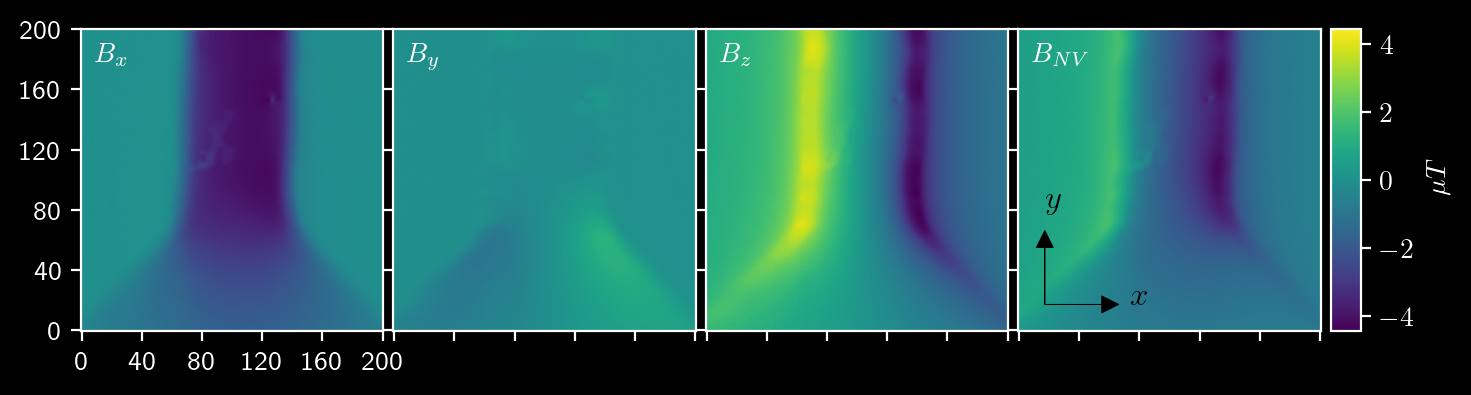

In [106]:
pipe = Pipe([  
    # NV stands for nitrogen-vacancy (its a quantum defect in diamond crystal used for measuring magnetic field and quantum computing)
    ('B+B_NV', Union([
        ('B', 'passthrough'),
        ('B_NV', Projection(theta=theta, phi=phi)),
    ], dim=-3)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[None, [-1], :, :])),
    ('padded_B_NV', Padder(up_to=(16*20, 16*20))),
])

pipe.fit(B).transform(B);

model = Pipe([
    # ('JxJy', Union([('Jx', FourierZeroDivergenceConstraint2d()), ('Jy', 'passthrough')], dim=-3)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=BnCNN, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

  epoch    train_loss       dur
-------  ------------  --------
      1      2.44e+00  2.21e-01
     20      1.06e+00  1.66e-01
     40      2.65e-02  3.16e-01
     60      8.36e-03  2.20e-01
     80      5.23e-03  1.85e-01
    100      5.58e-03  2.08e-01
    120      3.32e-03  1.82e-01
    140      2.85e-03  1.92e-01
    160      3.22e-03  1.92e-01
    180      2.35e-03  2.02e-01
    200      1.88e-03  1.97e-01


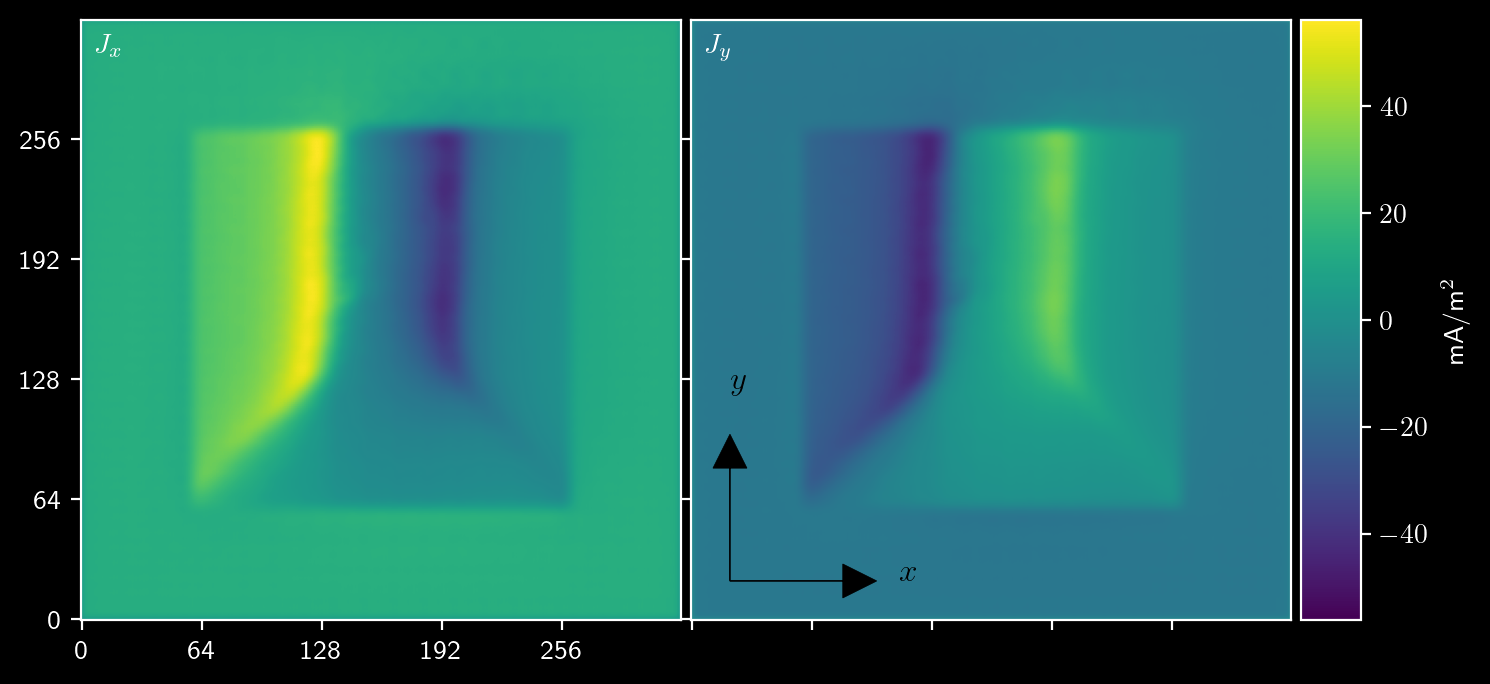

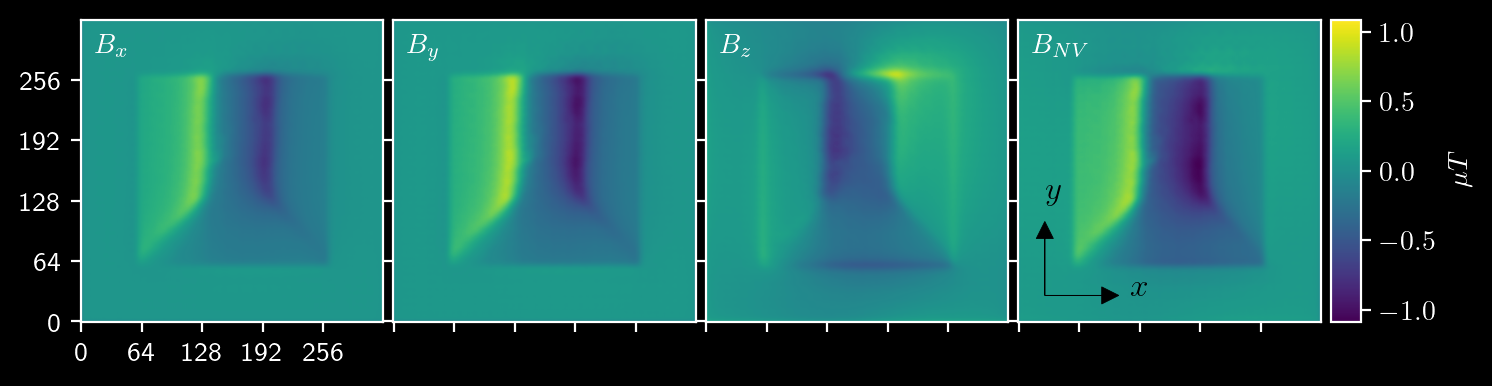

tensor([[[[-0.1112, -0.0682, -0.0451,  ..., -0.0955, -0.1161, -0.1304],
          [-0.0634, -0.0021,  0.0342,  ..., -0.0223, -0.0599, -0.0880],
          [-0.0353,  0.0372,  0.0829,  ...,  0.0196, -0.0275, -0.0641],
          ...,
          [-0.0797, -0.0129,  0.0270,  ..., -0.0320, -0.0744, -0.1072],
          [-0.1032, -0.0507, -0.0191,  ..., -0.0723, -0.1048, -0.1286],
          [-0.1241, -0.0868, -0.0627,  ..., -0.1096, -0.1305, -0.1435]]]],
       grad_fn=<IndexBackward0>)

In [107]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=0.1)

# Masks

Masks are difficult, because they need to be expanded according to the size of the input. 

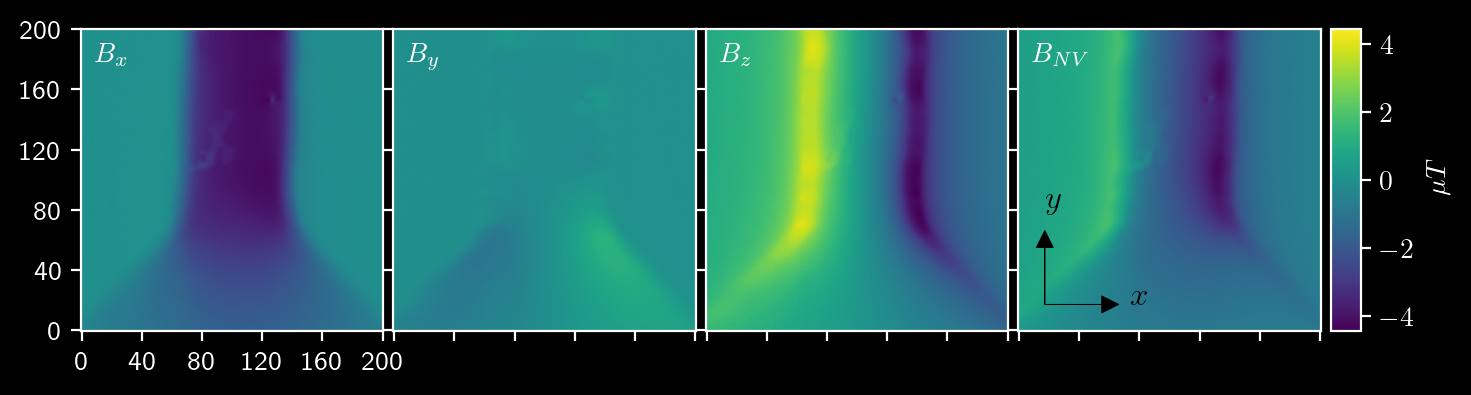

In [94]:
padder = Padder(up_to=(16*20, 16*20))

pipe = Pipe([  
    # NV stands for nitrogen-vacancy (its a quantum defect in diamond crystal used for measuring magnetic field and quantum computing)
    ('B+B_NV', Union([
        ('B', 'passthrough'),
        ('B_NV', Projection(theta=theta, phi=phi)),
    ], dim=-3)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[None, [-1], :, :])),
    ('padded_B_NV', padder),
])

pipe.fit(B).transform(B);

padding = padder.padding
threshold = -0.2
mask = torch.where(B[0] < threshold, torch.ones_like(B[0]), torch.zeros_like(B[0]))
mask = torch.nn.functional.pad(mask, (0, 0, padding[-3], padding[-4]), mode='constant', value=0.0)
mask = torch.nn.functional.pad(mask, (padding[-1], padding[-2], 0, 0), mode='constant', value=1.0)
def apply_mask(x):
    masked_x = mask * x
    return masked_x

mask_fn = Function(apply_mask)

model = Pipe([
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('mask', mask_fn),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=UNet, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

  epoch    train_loss       dur
-------  ------------  --------
    421      2.99e-02  3.21e-01
    440      4.43e-02  2.86e-01
    460      3.57e-02  8.42e-01
    480      3.52e-02  4.33e-01
    500      3.50e-02  2.66e-01
    520      3.66e-02  6.38e-01
    540      3.53e-02  5.00e-01


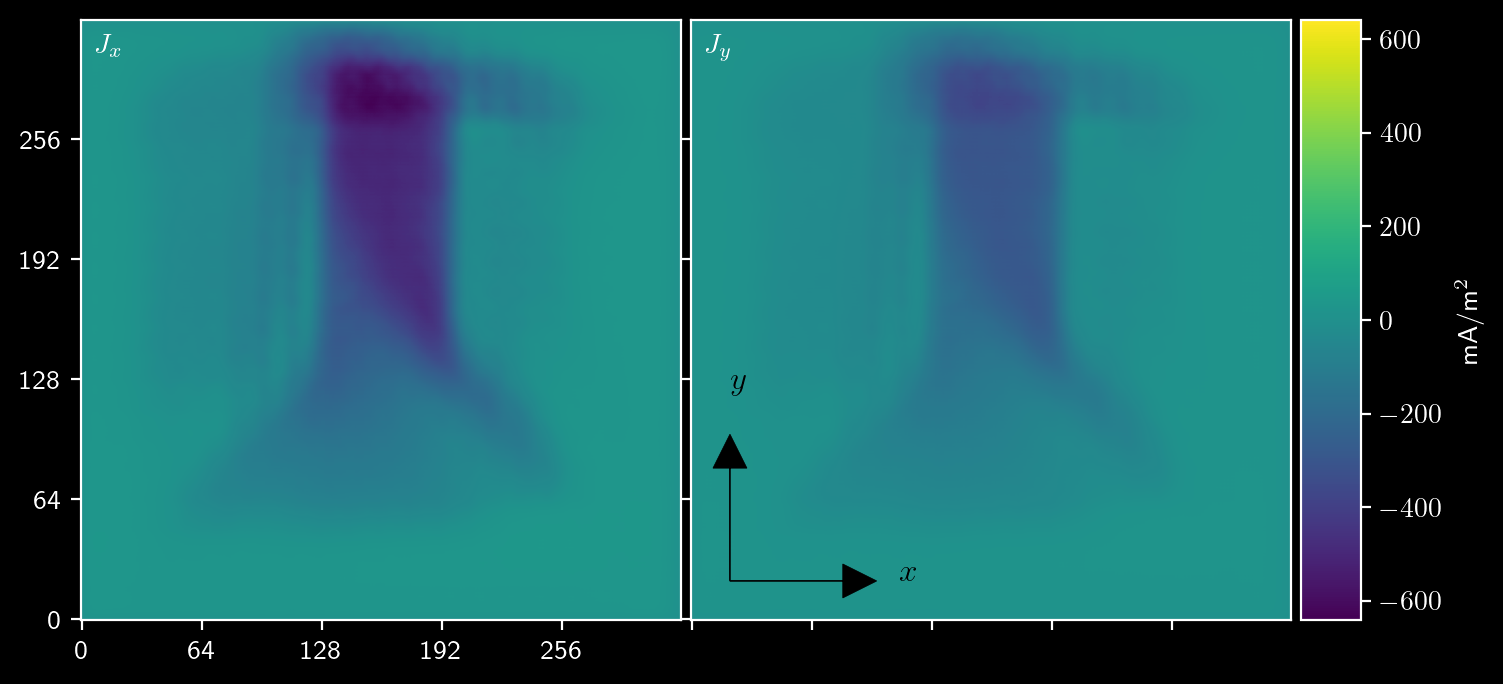

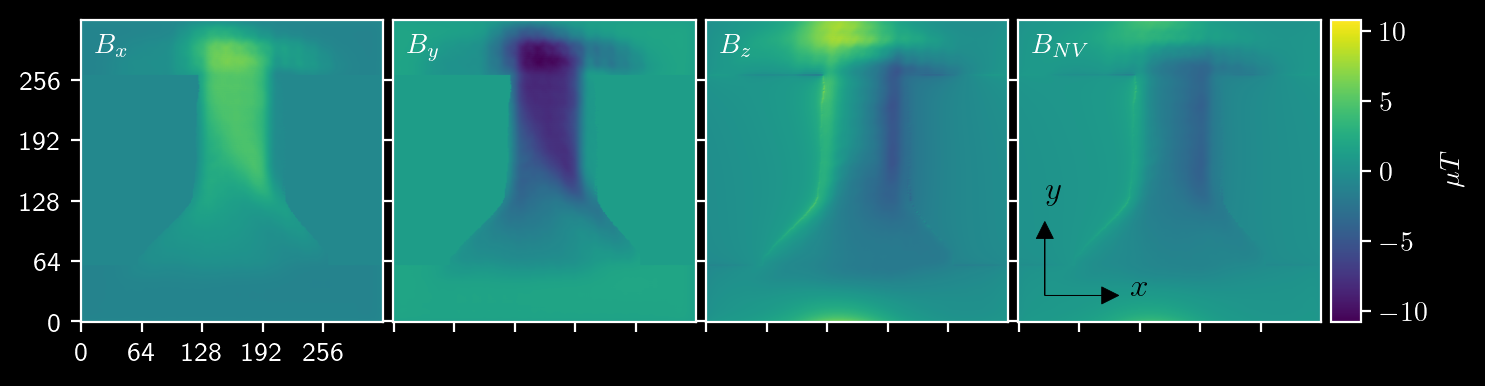

tensor([[[[0.4899, 0.4952, 0.4943,  ..., 0.4009, 0.4208, 0.4575],
          [0.5160, 0.5245, 0.5270,  ..., 0.3991, 0.4180, 0.4656],
          [0.5463, 0.5598, 0.5645,  ..., 0.3985, 0.4176, 0.4776],
          ...,
          [0.5242, 0.5405, 0.5550,  ..., 0.4373, 0.4474, 0.4810],
          [0.5055, 0.5197, 0.5311,  ..., 0.4308, 0.4422, 0.4702],
          [0.4815, 0.4886, 0.4906,  ..., 0.4146, 0.4317, 0.4583]]]],
       grad_fn=<IndexBackward0>)

In [99]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=0.1)

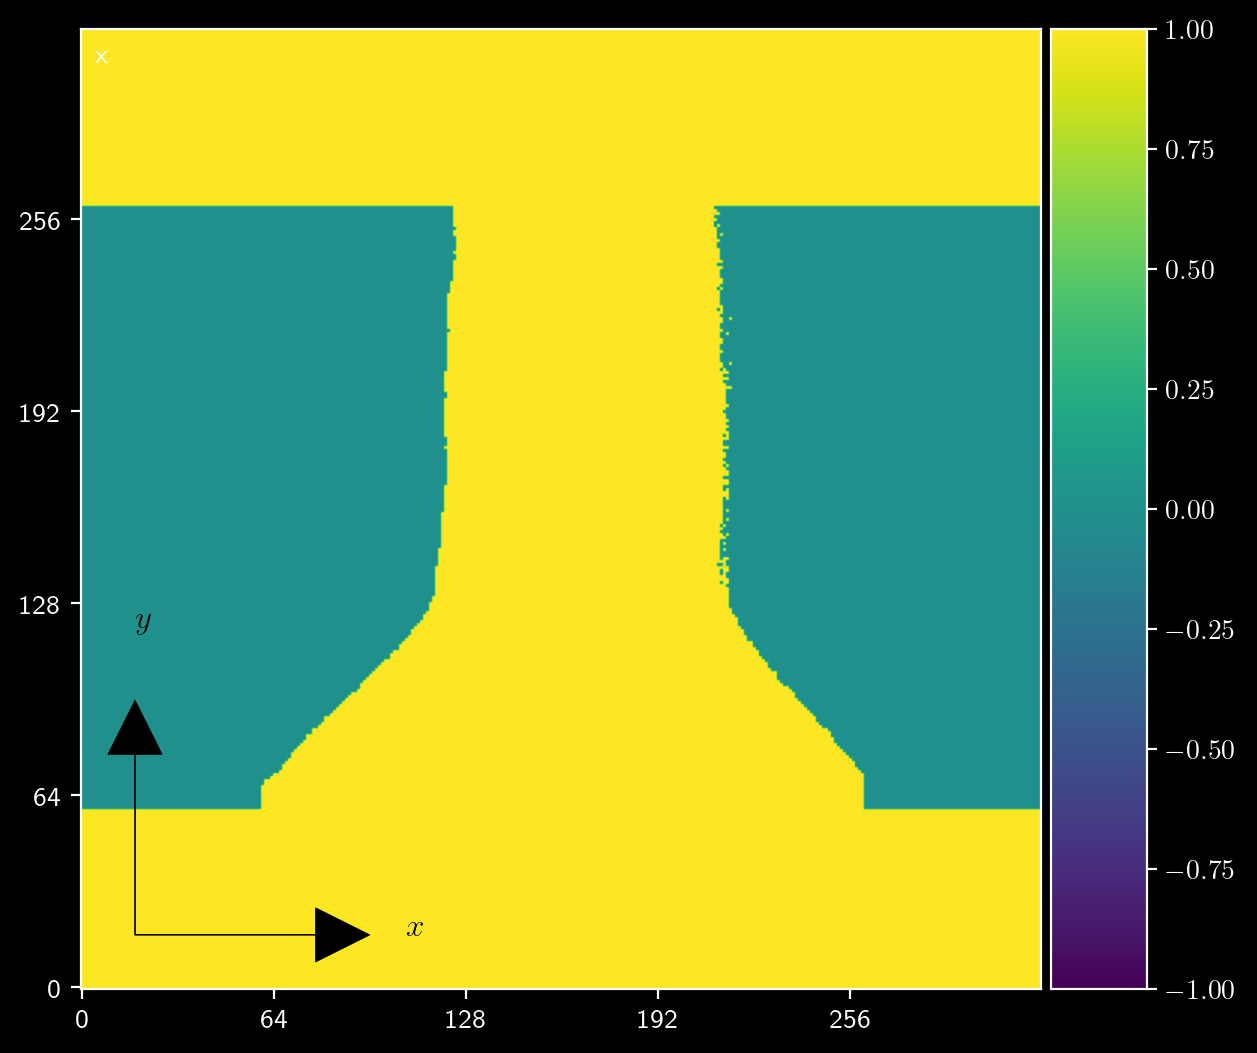

In [100]:
plot_n_components(mask)

# Proper PINN

Here we try to define a PINN that encodes the physics of the problem and models the $J$ as a function of grid points $x$ and $y$, that is, the neural network function $u_{NN}$ encodes $J(x, y) = u_{NN}(x, y)$ and it uses the PDEs known for the problem to constrain the solution.

In [53]:
xN, yN = B.shape[-2:]
xD, yD = 50, 50
xs = torch.linspace(0, xN + 2 * xD, xN + 2 * xD, requires_grad=True)
ys = torch.linspace(0, yN + 2 * yD, yN + 2 * yD, requires_grad=True)
mesh = torch.stack(torch.meshgrid(xs, ys, indexing="xy"), dim=0)
n_channels_in = 2
n_channels_out = 2

net = FCCNN(n_channels_in=n_channels_in, n_channels_out=n_channels_out)

J = net(mesh)
loss_fn = torch.nn.MSELoss()


def div(J):
    # J is a tensor of shape (2, H, W)
    # mesh is a tensor of shape (2, H, W)
    # we want to compute the divergence of J at each point in mesh
    # to do this we take the partial derivatives of J with respect to x and y
    # and then sum them together
    dJ = torch.autograd.grad(
        J, mesh, grad_outputs=torch.ones_like(J), create_graph=True
    )
    return dJ[0][0, :, :] + dJ[0][1, :, :]


# define a region of interest
# x0, x1, y0, y1 are the bounds of the measurement region
ROI = (
    (mesh[0, :, :] > xD)
    & (mesh[0, :, :] < xN - xD)
    & (mesh[1, :, :] > yD)
    & (mesh[1, :, :] < yN - yD)
)


def loss(J):
    term1 = loss_fn(div(J), torch.zeros_like(div(J)))
    term2 = loss_fn(model(J), B)

In [54]:
J[:, ROI]

/var/folders/9m/5d950qgd7tb27kf_yts_tr2r0000gn/T/ipykernel_30838/374784209.py:1: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1660136240338/work/aten/src/ATen/native/IndexingUtils.h:28.)
  J[:, ROI]


IndexError: The shape of the mask [10201] at index 0 does not match the shape of the indexed tensor [2, 301, 301] at index 1

In [36]:
J.shape

torch.Size([2, 301, 301])